## **Bab 1: Persiapan Lingkungan & Pustaka (Environment Setup)**


### **1.1 Instalasi Pustaka (Library Installation)**


In [ ]:
# -q digunakan untuk mode 'quiet' agar output log tidak terlalu panjang
!pip install -q google-play-scraper
!pip install -q transformers
!pip install -q torch
!pip install -q vaderSentiment
!pip install -q Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.3 MB/s eta 0:00:00


### **1.2 Impor Pustaka (Import Libraries)**


In [ ]:
# data manupulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import random
from tqdm import tqdm

# scraping
from google_play_scraper import Sort, reviews

# text preprocessing (NLP)
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# machine learning & metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# dee learning (PyTorch & Transformer)
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# konfigurasi visualisasi
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)

### **1.3 Konfigurasi Perangkat (Device Configuration)**


In [ ]:
# Cek apakah GPU tersedia
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Menggunakan GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU tidak terdeteksi. Menggunakan CPU (Proses training akan lambat).")

Menggunakan GPU: Tesla T4


### **1.4 Pengaturan Seed (Reproducibility)**


In [ ]:
def set_seed(seed_value=42):
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# set seed
SEED = 42
set_seed(SEED)

## **Bab 2: Akuisisi Data (Data Acquisition)**


### **2.1 Scraping Data dari Google Play Store**


In [ ]:
# Konfigurasi Scraping
APP_ID = 'com.linkdokter.halodoc.android'
LANG = 'id'
COUNTRY = 'id'

COUNT_PER_FILTER = 30000

def scrape_google_play(sort_type, count, score_filter=None):
    try:
        result, _ = reviews(
            APP_ID,
            lang=LANG,
            country=COUNTRY,
            sort=sort_type,
            count=count,
            filter_score_with=score_filter
        )
        return result
    except Exception as e:
        print(f"Terjadi kesalahan saat scraping (Sort: {sort_type}, Score: {score_filter}): {e}")
        return []

# List untuk menampung semua hasil scraping sementara
all_scraped_data = []

print(f"Memulai proses scraping untuk App ID: {APP_ID}...")

# 1. Scrape berdasarkan TERBARU (Newest)
print("   - Mengambil ulasan Terbaru...")
newest_data = scrape_google_play(Sort.NEWEST, COUNT_PER_FILTER)
all_scraped_data.extend(newest_data)

# 2. Scrape berdasarkan PALING RELEVAN (Most Relevant)
print("   - Mengambil ulasan Paling Relevan...")
relevant_data = scrape_google_play(Sort.MOST_RELEVANT, COUNT_PER_FILTER)
all_scraped_data.extend(relevant_data)

# 3. Scrape berdasarkan RATING (Bintang 1 sampai 5)
for score in range(1, 6):
    print(f"   - Mengambil ulasan dengan Rating {score}...")
    score_data = scrape_google_play(Sort.NEWEST, COUNT_PER_FILTER, score_filter=score)
    all_scraped_data.extend(score_data)

# Konversi ke DataFrame
df_scraped = pd.DataFrame(all_scraped_data)

# Pilih hanya kolom yang relevan agar hemat memori
df_scraped = df_scraped[['content', 'score', 'at']]

print(f"Scraping selesai! Total data mentah terkumpul: {len(df_scraped)} baris.")
display(df_scraped.head())

🚀 Memulai proses scraping untuk App ID: com.linkdokter.halodoc.android...
   - Mengambil ulasan Terbaru...
   - Mengambil ulasan Paling Relevan...
   - Mengambil ulasan dengan Rating 1...
   - Mengambil ulasan dengan Rating 2...
   - Mengambil ulasan dengan Rating 3...
   - Mengambil ulasan dengan Rating 4...
   - Mengambil ulasan dengan Rating 5...
✅ Scraping selesai! Total data mentah terkumpul: 111445 baris.


,content,score,at
0,mantappppp,5,2026-01-09 07:58:57
1,dokter baik.memberi resep&konsultasi yg baik.t...,4,2026-01-09 07:08:52
2,dokternya ramah dan sangat membantu orang awam...,5,2026-01-09 05:40:40
3,"Respon cepat ,pengiriman obat pun cepat .. dim...",5,2026-01-09 02:59:11
4,Bagus Dr Irma,5,2026-01-09 02:46:31


### **2.2 Memuat Dataset Eksternal**


In [ ]:
EXTERNAL_FILENAME = 'hasil_scraper_ulasan_app_Halodoc.csv'

# Cek apakah file ada
if os.path.exists(EXTERNAL_FILENAME):
    print(f"Memuat file eksternal: {EXTERNAL_FILENAME}")
    df_external = pd.read_csv(EXTERNAL_FILENAME)

    # Menampilkan 5 baris pertama untuk inspeksi kolom
    print("Preview Data Eksternal:")
    display(df_external.head())
else:
    # Buat dummy dataframe jika file belum diupload agar kode tidak error saat demo
    print(f"File '{EXTERNAL_FILENAME}' tidak ditemukan!")
    df_external = pd.DataFrame(columns=['Review Text', 'Rating', 'Date'])

📂 Memuat file eksternal: hasil_scraper_ulasan_app_Halodoc.csv
Preview Data Eksternal:


,Review ID,Username,Rating,Review Text,Date
0,e59aed9e-4902-4356-9c7e-49e33d00e5a0,Pengguna Google,5,bagus membantu,2026-01-08 23:55:53
1,369db14e-7cbe-4171-a455-d352780ceaf0,Pengguna Google,5,sangat dibutuhkan untuk kehidupan sehari-hari,2026-01-08 21:47:22
2,982bbc3b-1702-4106-a519-6d11b23b5323,Pengguna Google,5,"chek dan periksa dokter, mudah, respon cepat, ...",2026-01-08 19:37:40
3,c5fa657d-44cd-42cb-8acf-b519de93fc76,Pengguna Google,5,layanan terbaik,2026-01-08 13:16:35
4,9d3f2029-dc4c-426d-b7e1-8f2e9f26b54c,Pengguna Google,5,singkat padat jelas dan privasi terjaga,2026-01-08 12:57:11


### **2.3 Standardisasi Kolom (Column Standardization)**


In [ ]:
# Target kita adalah kolom: 'content' dan 'score'

if not df_external.empty:
    # Mapping nama kolom lama -> nama kolom baru
    rename_map = {
        'Review Text': 'content',
        'Rating': 'score',
        'Date': 'at' # Opsional, jika ada kolom tanggal
    }

    # Lakukan rename
    df_external = df_external.rename(columns=rename_map)

    # Pastikan hanya mengambil kolom yang dibutuhkan
    # Menggunakan intersection agar tidak error jika kolom 'at' tidak ada
    cols_to_keep = ['content', 'score']
    if 'at' in df_external.columns:
        cols_to_keep.append('at')

    df_external = df_external[cols_to_keep]

    print("Kolom dataset eksternal berhasil distandardisasi.")
    display(df_external.head())
else:
    print("ℹDataset eksternal kosong, melewati tahap standardisasi.")

Kolom dataset eksternal berhasil distandardisasi.


,content,score,at
0,bagus membantu,5,2026-01-08 23:55:53
1,sangat dibutuhkan untuk kehidupan sehari-hari,5,2026-01-08 21:47:22
2,"chek dan periksa dokter, mudah, respon cepat, ...",5,2026-01-08 19:37:40
3,layanan terbaik,5,2026-01-08 13:16:35
4,singkat padat jelas dan privasi terjaga,5,2026-01-08 12:57:11


## **Bab 3: Integrasi & Pembersihan Data (Data Integration & Cleaning)**


### **3.1 Penggabungan Data (Data Merging)**


In [ ]:
# Menggabungkan kedua dataframe
# ignore_index=True penting agar index direset ulang dari 0 sampai n
halodoc_reviews = pd.read_csv('halodoc_reviews.csv')
df_combined = pd.concat([df_scraped, df_external, halodoc_reviews], ignore_index=True)

print(f"Statistik Awal:")
print(f"   - Jumlah data hasil scraping sendiri : {len(df_scraped)}")
print(f"   - Jumlah data eksternal            : {len(df_external)}")
print(f"   - Total data sebelum pembersihan   : {len(df_combined)}")

# Menampilkan info tipe data
print("\nℹInfo Dataset Gabungan:")
df_combined.info()

📊 Statistik Awal:
   - Jumlah data hasil scraping sendiri : 111445
   - Jumlah data eksternal            : 30000
   - Total data sebelum pembersihan   : 190396

ℹ️ Info Dataset Gabungan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190396 entries, 0 to 190395
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  190396 non-null  object
 1   score    190396 non-null  int64 
 2   at       141445 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.4+ MB


### **3.2 Penanganan Duplikasi (Handling Duplicates)**


In [ ]:
# Cek jumlah duplikat berdasarkan konten ulasan
duplicate_count = df_combined.duplicated(subset=['content']).sum()

print(f"Terdeteksi {duplicate_count} data duplikat.")

if duplicate_count > 0:
    # Menghapus duplikat, simpan yang pertama ditemukan (keep='first')
    df_clean = df_combined.drop_duplicates(subset=['content'], keep='first')
    print(f"Membersihkan duplikat... Selesai.")
else:
    df_clean = df_combined.copy()
    print("Tidak ada duplikat yang perlu dihapus.")

print(f"   - Sisa data setelah hapus duplikat: {len(df_clean)}")

Terdeteksi 136676 data duplikat.
🧹 Membersihkan duplikat... Selesai.
   - Sisa data setelah hapus duplikat: 53720


### **3.3 Penanganan Missing Values & Data Kosong**


In [ ]:
# 1. Cek Missing Values (NaN)
nan_count = df_clean['content'].isna().sum()
if nan_count > 0:
    print(f"Ditemukan {nan_count} baris dengan konten NaN. Menghapusnya...")
    df_clean = df_clean.dropna(subset=['content'])

In [ ]:
# 2. Pastikan tipe data adalah string
df_clean['content'] = df_clean['content'].astype(str)

/tmp/ipython-input-1985612234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['content'] = df_clean['content'].astype(str)


In [ ]:
# 3. Hapus ulasan yang hanya berisi whitespace (spasi kosong)
# Contoh: "   " atau ""
initial_len = len(df_clean)
df_clean = df_clean[df_clean['content'].str.strip() != ""]
whitespace_count = initial_len - len(df_clean)

if whitespace_count > 0:
    print(f"Menghapus {whitespace_count} ulasan yang hanya berisi spasi kosong.")

# Reset index agar rapi (0, 1, 2, ... n)
df_clean = df_clean.reset_index(drop=True)

### **3.4 Seleksi Fitur Akhir**


In [ ]:
# Kita hanya ambil kolom yang dibutuhkan
df_final = df_clean[['content', 'score']].copy()

# Preview data akhir
print("Preview Master Dataset:")
display(df_final.head())

Preview Master Dataset:


,content,score
0,mantappppp,5
1,dokter baik.memberi resep&konsultasi yg baik.t...,4
2,dokternya ramah dan sangat membantu orang awam...,5
3,"Respon cepat ,pengiriman obat pun cepat .. dim...",5
4,Bagus Dr Irma,5


/tmp/ipython-input-3126144270.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=df_final, palette='viridis')


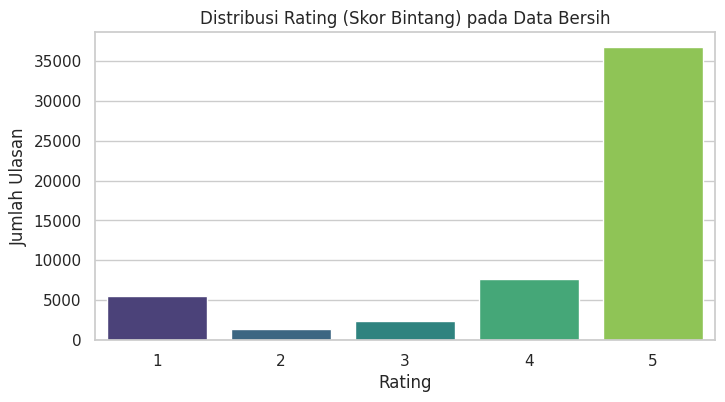

In [ ]:
# Cek distribusi rating sementara (sebelum labeling VADER)
plt.figure(figsize=(8, 4))
sns.countplot(x='score', data=df_final, palette='viridis')
plt.title('Distribusi Rating (Skor Bintang) pada Data Bersih')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()

## **Bab 4: Pra-pemrosesan Teks (Text Preprocessing)**

### **4.1 Kamus Normalisasi (Slang Dictionary)**


In [ ]:
# Kamus slang words (bisa ditambahkan sesuai kebutuhan dataset)
# Ini adalah daftar kata yang sering muncul di ulasan aplikasi kesehatan
normalisasi_kamus = {
    'yg': 'yang', 'gk': 'tidak', 'gak': 'tidak', 'ga': 'tidak', 'g': 'tidak',
    'bgt': 'banget', 'dr': 'dokter', 'kalo': 'kalau', 'klo': 'kalau',
    'blm': 'belum', 'sdh': 'sudah', 'udh': 'sudah', 'dgn': 'dengan',
    'tdk': 'tidak', 'tpi': 'tapi', 'tp': 'tapi', 'krn': 'karena',
    'pke': 'pakai', 'pake': 'pakai', 'sy': 'saya', 'aku': 'saya',
    'gw': 'saya', 'gue': 'saya', 'jd': 'jadi', 'jdi': 'jadi',
    'bisa': 'bisa', 'bs': 'bisa', 'dpt': 'dapat', 'jgn': 'jangan',
    'utk': 'untuk', 'nya': 'nya', 'bnyk': 'banyak', 'dlm': 'dalam',
    'bgus': 'bagus', 'keren': 'keren', 'mantap': 'mantap',
    'min': 'admin', 'apk': 'aplikasi', 'app': 'aplikasi',
    'error': 'eror', 'lemot': 'lambat', 'lelet': 'lambat',
    'konsul': 'konsultasi', 'obat': 'obat', 'resep': 'resep',
    'chat': 'pesan', 'bales': 'balas', 'respon': 'respons',
    'cepet': 'cepat', 'cpt': 'cepat', 'mksih': 'terima kasih',
    'makasih': 'terima kasih', 'tks': 'terima kasih', 'thx': 'terima kasih',
    'good': 'bagus', 'bad': 'buruk', 'best': 'terbaik',
    'oke': 'oke', 'ok': 'oke', 'sip': 'sip',
    'mw': 'mau', 'mau': 'mau', 'trus': 'terus', 'trs': 'terus',
    'lg': 'lagi', 'lgi': 'lagi', 'sm': 'sama', 'sama': 'sama'
}

def normalisasi_kata(text):
    """Mengubah kata slang menjadi kata baku berdasarkan kamus."""
    words = text.split()
    # Mengganti kata jika ada di kamus, jika tidak biarkan
    normalized_words = [normalisasi_kamus.get(word, word) for word in words]
    return ' '.join(normalized_words)

### **4.2 Fungsi Pembersihan Teks (Cleaning Function)**


In [ ]:
def preprocess_text(text):
    """
    Pipeline preprocessing lengkap:
    1. Case folding (huruf kecil)
    2. Hapus URL & Username
    3. Hapus Angka & Tanda Baca
    4. Normalisasi Slang
    5. Hapus Spasi Berlebih
    """
    # 1. Case Folding
    text = text.lower()

    # 2. Hapus URL (http/https/www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Hapus Mention (@username) dan Hashtag (#topic)
    text = re.sub(r'@\w+|#\w+', '', text)

    # 4. Hapus Angka dan Tanda Baca (Hanya sisakan huruf a-z dan spasi)
    # Catatan: Untuk VADER, tanda baca kadang berguna (!), tapi untuk IndoBERT
    # yang bersih lebih baik agar vocab tidak meledak.
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # 5. Normalisasi Slang
    text = normalisasi_kata(text)

    # 6. Hapus single char yang tidak bermakna (misal: 'a', 'b', 'c' sisa typo)
    # Kecuali kata 'i' (di inggris) atau 'u' (you), tapi ini konteks indo.
    text = re.sub(r'\b[a-zA-Z]\b', '', text)

    # 7. Hapus spasi berlebih (whitespace)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

### **4.3 Eksekusi Preprocessing**


In [ ]:
# Mengaktifkan progress bar pandas
tqdm.pandas()

# Buat kolom baru 'text_clean' agar data asli 'content' tidak hilang (untuk perbandingan)
df_final['text_clean'] = df_final['content'].progress_apply(preprocess_text)

# Hapus data yang menjadi kosong setelah preprocessing (misal isinya cuma emoji/angka)
initial_len = len(df_final)
df_final = df_final[df_final['text_clean'] != '']
cleaned_len = len(df_final)

print(f"\nPreprocessing Selesai!")
print(f"   - Data awal: {initial_len}")
print(f"   - Data bersih: {cleaned_len} (Dihapus {initial_len - cleaned_len} baris kosong)")

100%|██████████| 53720/53720 [00:01<00:00, 41401.55it/s]


✅ Preprocessing Selesai!
   - Data awal: 53720
   - Data bersih: 53579 (Dihapus 141 baris kosong)


In [ ]:
# Menampilkan sampel perbandingan sebelum dan sesudah
print("\nSampel Hasil Preprocessing:")
print("="*80)
sample_data = df_final.sample(5, random_state=42)

for index, row in sample_data.iterrows():
    print(f"ORIGINAL : {row['content']}")
    print(f"CLEANED  : {row['text_clean']}")
    print("-" * 80)


Sampel Hasil Preprocessing:
ORIGINAL : Sangat membantu sekali ketika lemas ga bisa jalan kedokter dan bisa konsultasi layaknya ke klinik atau Rs...trm ksh halodoc
CLEANED  : sangat membantu sekali ketika lemas tidak bisa jalan kedokter dan bisa konsultasi layaknya ke klinik atau rs trm ksh halodoc
--------------------------------------------------------------------------------
ORIGINAL : Kenapa saya tidak dapat no verifikasinya udah nyoba 3x
CLEANED  : kenapa saya tidak dapat no verifikasinya udah nyoba
--------------------------------------------------------------------------------
ORIGINAL : Mantap sekali
CLEANED  : mantap sekali
--------------------------------------------------------------------------------
ORIGINAL : Engk gratis ya dok..
CLEANED  : engk gratis ya dok
--------------------------------------------------------------------------------
ORIGINAL : tidak sesuai deskripsi menhantarkan obat 1 jam.saya butuh obatnya tapi ditunggu 4jam tidak sampai.tidak bisa memantau status

In [ ]:
df_final.to_csv('halodoc_reviews_clean.csv', index=False)

## **Bab 5: Pelabelan Otomatis (Automatic Labeling with Pre-trained IndoBERT)**


### **5.1 Memuat Pre-trained Model untuk Labeling**


In [ ]:
df_final = pd.read_csv('halodoc_reviews_clean.csv')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53579 entries, 0 to 53578
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   content     53579 non-null  object
 1   score       53579 non-null  int64 
 2   text_clean  53579 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
from transformers import pipeline

# Nama model pre-trained yang spesifik untuk Analisis Sentimen Bahasa Indonesia
# Model ini sudah dilatih pada jutaan kalimat sentimen Indonesia
PRETRAINED_MODEL = "mdhugol/indonesia-bert-sentiment-classification"

print(f"Sedang mengunduh dan memuat model: {PRETRAINED_MODEL}...")

# Inisialisasi Pipeline
# device=0 artinya menggunakan GPU (jika ada), device=-1 artinya CPU
gpu_id = 0 if torch.cuda.is_available() else -1

sentiment_analysis = pipeline(
    "sentiment-analysis",
    model=PRETRAINED_MODEL,
    tokenizer=PRETRAINED_MODEL,
    device=gpu_id
)

print("Model Labeling siap digunakan!")

⬇️ Sedang mengunduh dan memuat model: mdhugol/indonesia-bert-sentiment-classification...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


✅ Model Labeling siap digunakan!


### **5.2 Proses Labeling (Inferensi)**


In [ ]:
def get_sentiment_label(texts):
    """
    Fungsi untuk memprediksi sentimen dari list teks.
    Mengembalikan list label (Positive, Negative, Neutral).
    """
    # Pipeline akan mengembalikan list of dict, misal: [{'label': 'POSITIVE', 'score': 0.99}]
    results = sentiment_analysis(texts, truncation=True, max_length=512)
    return [res['label'] for res in results]


batch_size = 100
labels = []
texts = df_final['text_clean'].tolist()

print(f"Memulai pelabelan otomatis untuk {len(texts)} data...")

for i in tqdm(range(0, len(texts), batch_size)):
    batch_texts = texts[i : i + batch_size]
    batch_texts = [t if t.strip() != "" else "netral" for t in batch_texts]

    batch_labels = get_sentiment_label(batch_texts)
    labels.extend(batch_labels)

# Simpan hasil ke DataFrame
df_final['sentiment_label'] = labels

print("\nPelabelan Selesai!")
display(df_final[['text_clean', 'sentiment_label']].head())

🚀 Memulai pelabelan otomatis untuk 53579 data...


100%|██████████| 536/536 [12:52<00:00,  1.44s/it]


✅ Pelabelan Selesai!


,text_clean,sentiment_label
0,mantappppp,LABEL_0
1,dokter baik memberi resep konsultasi yang baik...,LABEL_0
2,dokternya ramah dan sangat membantu orang awam...,LABEL_0
3,respons cepat pengiriman obat pun cepat dimana...,LABEL_0
4,bagus dokter irma,LABEL_0


### **5.3 Encoding Label (Konversi ke Angka)**


In [ ]:
# Cek dulu nilai unik apa saja yang keluar dari model
unique_labels = df_final['sentiment_label'].unique()
print(f"Label unik yang ditemukan: {unique_labels}")

# Mapping untuk label yang keluar dari model mdhugol/indonesia-bert-sentiment-classification
# Berdasarkan dokumentasi model atau observasi hasil inferensi:
# LABEL_0: Negative
# LABEL_1: Neutral
# LABEL_2: Positive
label_mapping = {
    'LABEL_0': 0, # Negative
    'LABEL_1': 1, # Neutral
    'LABEL_2': 2  # Positive
}

# Terapkan mapping
df_final['label'] = df_final['sentiment_label'].map(label_mapping)

# Hapus baris jika ada label yang gagal ter-mapping (NaN)
# Ini penting jika ada label tak terduga dari model yang tidak ada di mapping
df_final = df_final.dropna(subset=['label'])
df_final['label'] = df_final['label'].astype(int)

display(df_final[['text_clean', 'sentiment_label', 'label']].head())

Label unik yang ditemukan: ['LABEL_0' 'LABEL_1' 'LABEL_2']


,text_clean,sentiment_label,label
0,mantappppp,LABEL_0,0
1,dokter baik memberi resep konsultasi yang baik...,LABEL_0,0
2,dokternya ramah dan sangat membantu orang awam...,LABEL_0,0
3,respons cepat pengiriman obat pun cepat dimana...,LABEL_0,0
4,bagus dokter irma,LABEL_0,0


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53579 entries, 0 to 53578
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   content          53579 non-null  object
 1   score            53579 non-null  int64 
 2   text_clean       53579 non-null  object
 3   sentiment_label  53579 non-null  object
 4   label            53579 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


### **5.4 Visualisasi Hasil Labeling**


/tmp/ipython-input-2889727827.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment_label', data=df_final, palette='coolwarm', order=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])


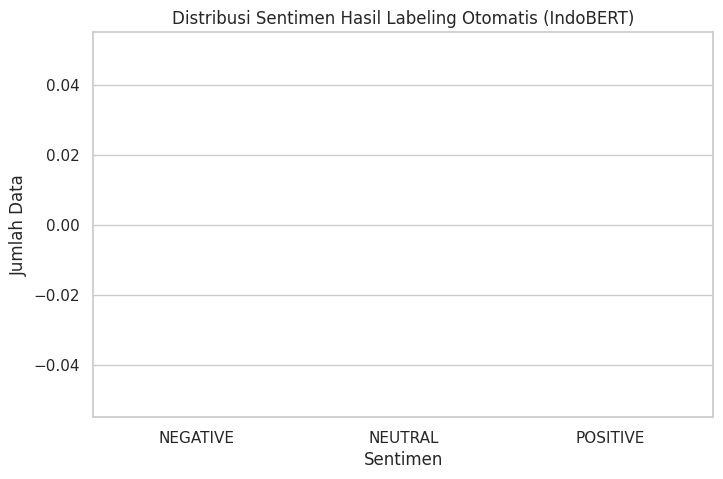

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='sentiment_label', data=df_final, palette='coolwarm', order=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])

plt.title('Distribusi Sentimen Hasil Labeling Otomatis (IndoBERT)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Data')

# Menambahkan angka di atas batang
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [ ]:
df_final.to_csv('halodoc_reviews_labeled.csv', index=False)

## **Bab 6: Exploratory Data Analysis (EDA)**

In [ ]:
df_final = pd.read_csv('halodoc_reviews_labeled.csv')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53579 entries, 0 to 53578
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   content          53579 non-null  object
 1   score            53579 non-null  int64 
 2   text_clean       53579 non-null  object
 3   sentiment_label  53579 non-null  object
 4   label            53579 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


In [ ]:
# Mapping yang terbalik: LABEL_0 seharusnya Positif, LABEL_2 seharusnya Negatif
corrected_label_mapping_label = {
    'LABEL_0': 2, # Sekarang 2 (sebelumnya Negatif) menjadi Positif
    'LABEL_1': 1, # Netral tetap netral
    'LABEL_2': 0  # Sekarang 0 (sebelumnya Positif) menjadi Negatif
}

corrected_label_mapping_sentiment_label = {
    'LABEL_0': 'Positif', # Sekarang 0 (sebelumnya Negatif) menjadi Positif
    'LABEL_1': 'Netral', # Netral tetap netral
    'LABEL_2': 'Negatif'  # Sekarang 2 (sebelumnya Positif) menjadi Negatif
}

# Terapkan mapping yang sudah dikoreksi ke kolom 'label'
df_final['label'] = df_final['sentiment_label'].map(corrected_label_mapping_label)

# Terapkan mapping yang sudah dikoreksi ke kolom 'sentiment_label'
df_final['sentiment_label'] = df_final['sentiment_label'].map(corrected_label_mapping_sentiment_label)

# Pastikan tidak ada NaN setelah mapping dan ubah ke integer
df_final = df_final.dropna(subset=['label'])
df_final['label'] = df_final['label'].astype(int)

print("Label 0 dan 2 berhasil dibalik!")

Label 0 dan 2 berhasil dibalik!


In [ ]:
display(df_final[['text_clean', 'sentiment_label', 'label']].head(20))

,text_clean,sentiment_label,label
0,mantappppp,Positif,2
1,dokter baik memberi resep konsultasi yang baik...,Positif,2
2,dokternya ramah dan sangat membantu orang awam...,Positif,2
3,respons cepat pengiriman obat pun cepat dimana...,Positif,2
4,bagus dokter irma,Positif,2
5,terima kasih halodoc,Positif,2
6,bagus membantu,Positif,2
7,sangat dibutuhkan untuk kehidupan sehari hari,Positif,2
8,chek dan periksa dokter mudah respons cepat da...,Positif,2
9,layanan terbaik,Positif,2


In [ ]:
df_final[df_final['label'] == 0].head(50)

,content,score,text_clean,sentiment_label,label
20,Dokter tidak ramah,1,dokter tidak ramah,Negatif,0
27,mau konsultasi tapi tdk ada riwayat cat sy mau...,1,mau konsultasi tapi tidak ada riwayat cat saya...,Negatif,0
46,gajelas banget setiap di pake selalu aja gak b...,1,gajelas banget setiap di pakai selalu aja tida...,Negatif,0
47,Ribet banget orang butuh cepat obatlun susah k...,1,ribet banget orang butuh cepat obatlun susah k...,Negatif,0
61,slowrespon,2,slowrespon,Negatif,0
62,aplikasinya membantu cuman penananganya dan re...,5,aplikasinya membantu cuman penananganya dan re...,Negatif,0
80,awalnya dokter merespon lalu tidak ada respon ...,1,awalnya dokter merespon lalu tidak ada respons...,Negatif,0
88,"sumpah ini aplikasi bad bgt ngeselin sumpah, b...",1,sumpah ini aplikasi buruk banget ngeselin sump...,Negatif,0
90,kenapa setiap mau melakukan pembayaran ketika ...,1,kenapa setiap mau melakukan pembayaran ketika ...,Negatif,0
94,Baru kali ini konsul halodoc mengecewakan bang...,2,baru kali ini konsultasi halodoc mengecewakan ...,Negatif,0


In [ ]:
# Simpan kembali DataFrame dengan label yang sudah dikoreksi
df_final.to_csv('halodoc_reviews_corrected_labeled.csv', index=False)

### **6.1 Distribusi Sentimen (Persentase)**


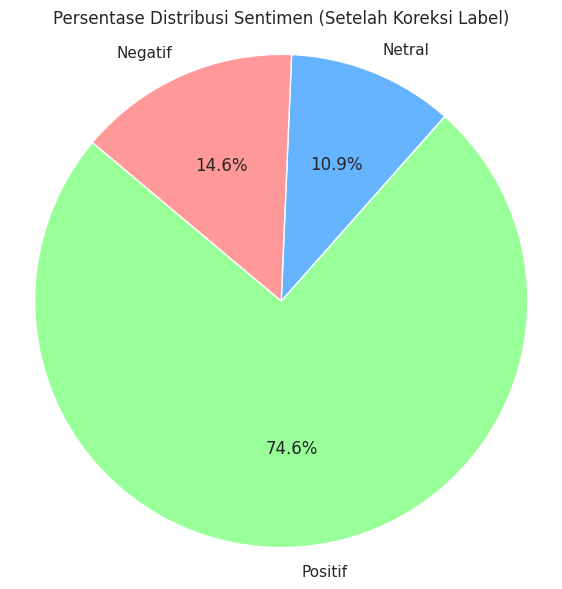

Analisis:
Data terindikasi Imbalanced (Timpang).
Saran: Nanti saat training, kita bisa gunakan 'Weighted Loss' atau teknik sampling jika akurasi kelas minoritas buruk.


In [ ]:
# Definisikan urutan label yang diinginkan untuk pie chart
desired_label_order = ['Positif', 'Netral', 'Negatif']

# Hitung jumlah per label dari kolom sentiment_label yang sudah berupa string
label_counts = df_final['sentiment_label'].value_counts()

# Susun ulang label_counts sesuai urutan yang diinginkan
label_counts_ordered = label_counts.reindex(desired_label_order)

plt.figure(figsize=(7, 7))
# Gunakan label_counts_ordered.index untuk label, dan atur warna sesuai urutan
plt.pie(label_counts_ordered, labels=label_counts_ordered.index, autopct='%1.1f%%', startangle=140,
        colors=['#99ff99', '#66b3ff', '#ff9999']) # Warna pastel: Hijau (Positif), Biru (Netral), Merah (Negatif)
plt.title('Persentase Distribusi Sentimen (Setelah Koreksi Label)')
plt.axis('equal')  # Agar lingkaran sempurna
plt.show()

print("Analisis:")
if label_counts.min() / label_counts.max() < 0.2:
    print("Data terindikasi Imbalanced (Timpang).")
    print("Saran: Nanti saat training, kita bisa gunakan 'Weighted Loss' atau teknik sampling jika akurasi kelas minoritas buruk.")
else:
    print("Data relatif seimbang. Aman untuk training standar.")

### **6.2 Analisis Panjang Kalimat (Word Count Distribution)**


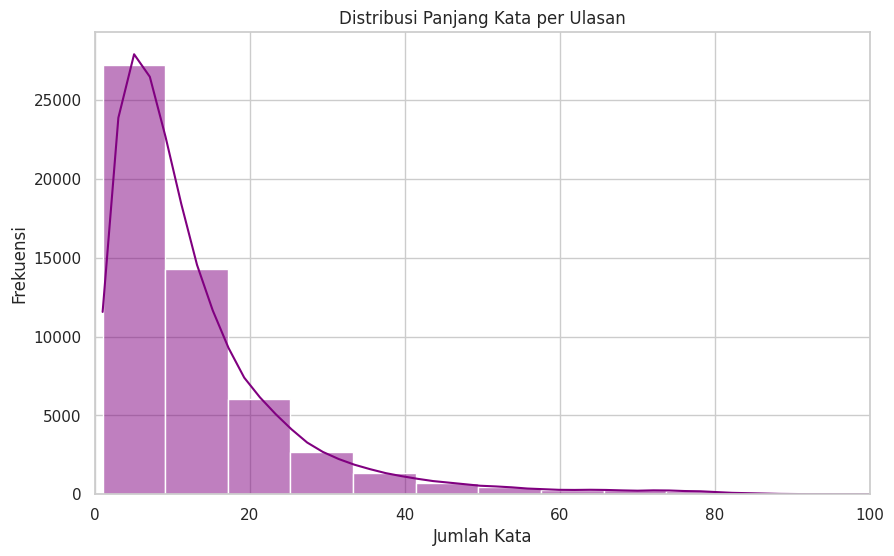

Statistik Panjang Kalimat:
   - Rata-rata kata : 12.95
   - Maksimum kata  : 405
   - 95% data memiliki panjang di bawah : 36 kata

REKOMENDASI: Set 'max_length' pada tokenisasi nanti sekitar 46 - 56.


In [ ]:
# Hitung jumlah kata per ulasan
df_final['word_count'] = df_final['text_clean'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_final['word_count'], bins=50, kde=True, color='purple')
plt.title('Distribusi Panjang Kata per Ulasan')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.xlim(0, 100) # Kita zoom in ke 0-100 kata karena ulasan app biasanya pendek
plt.show()

# Statistik Panjang Kata
avg_len = df_final['word_count'].mean()
max_len = df_final['word_count'].max()
percentile_95 = np.percentile(df_final['word_count'], 95)

print(f"Statistik Panjang Kalimat:")
print(f"   - Rata-rata kata : {avg_len:.2f}")
print(f"   - Maksimum kata  : {max_len}")
print(f"   - 95% data memiliki panjang di bawah : {percentile_95:.0f} kata")
print(f"\nREKOMENDASI: Set 'max_length' pada tokenisasi nanti sekitar {int(percentile_95) + 10} - {int(percentile_95) + 20}.")

### **6.3 Word Cloud (Visualisasi Kata Dominan)**


Word Cloud - Sentimen POSITIF


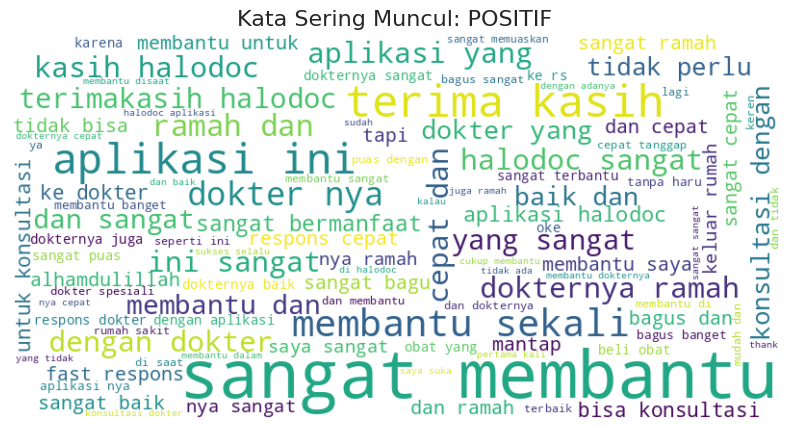

Word Cloud - Sentimen NEGATIF


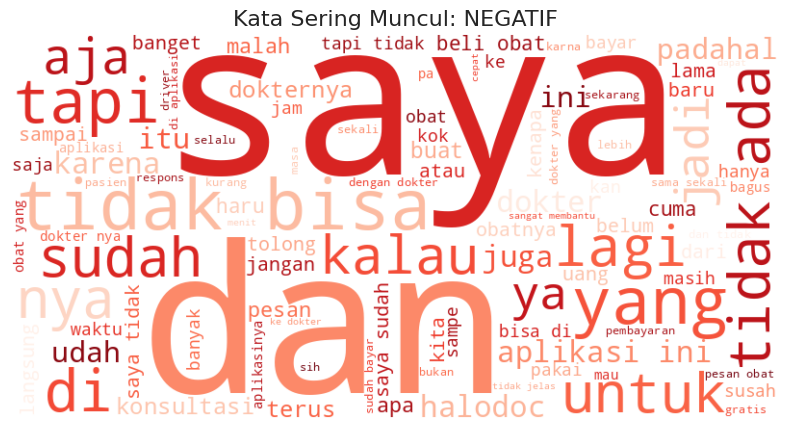

In [ ]:
from wordcloud import WordCloud

def generate_wordcloud(text_data, title, color_func=None):
    """Fungsi helper untuk membuat WordCloud."""
    all_text = ' '.join(text_data)

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap=color_func,
                          max_words=100).generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# 1. Word Cloud Sentimen POSITIF (LABEL_0 setelah dibalik)
print("Word Cloud - Sentimen POSITIF")
positive_text = df_final[df_final['label'] == 2]['text_clean'] # 2 adalah label untuk positif setelah dibalik
generate_wordcloud(positive_text, "Kata Sering Muncul: POSITIF", 'viridis')

# 2. Word Cloud Sentimen NEGATIF (LABEL_2 setelah dibalik)
print("Word Cloud - Sentimen NEGATIF")
negative_text = df_final[df_final['label'] == 0]['text_clean'] # 0 adalah label untuk negatif setelah dibalik
generate_wordcloud(negative_text, "Kata Sering Muncul: NEGATIF", 'Reds')

### **6.4 Analisis N-Grams (Frasa Paling Sering Muncul)**


/tmp/ipython-input-46859357.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, palette='Reds_r')


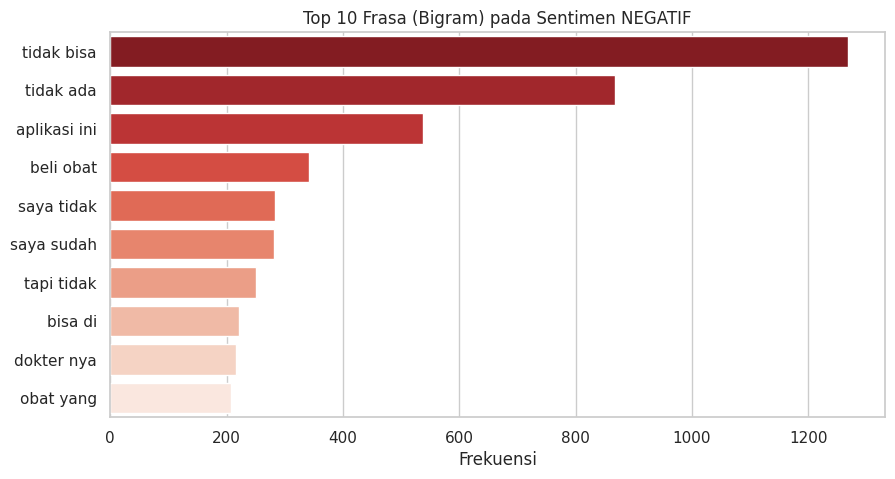

Analisis Singkat:
Frasa negatif terbanyak: ['tidak bisa', 'tidak ada', 'aplikasi ini']


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigram(corpus, n=None):
    """Mencari frasa 2 kata (bigram) terbanyak."""
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Ambil Top 10 Bigram dari ulasan Negatif
top_bigrams_neg = get_top_n_bigram(df_final[df_final['label'] == 0]['text_clean'], n=10)
x, y = map(list, zip(*top_bigrams_neg))

plt.figure(figsize=(10, 5))
sns.barplot(x=y, y=x, palette='Reds_r')
plt.title('Top 10 Frasa (Bigram) pada Sentimen NEGATIF')
plt.xlabel('Frekuensi')
plt.show()

print("Analisis Singkat:")
print(f"Frasa negatif terbanyak: {x[:3]}")

/tmp/ipython-input-3918861146.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, palette='Greens_r')


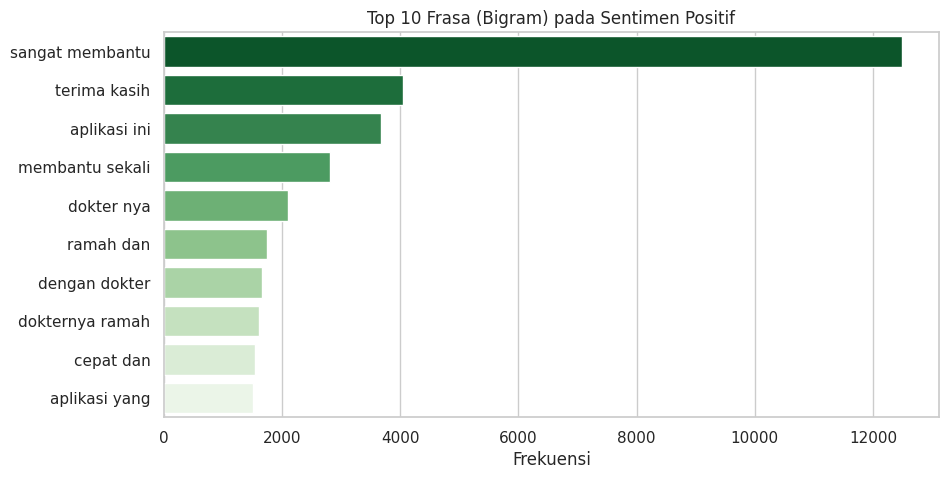

Analisis Singkat:
Frasa Positif terbanyak: ['sangat membantu', 'terima kasih', 'aplikasi ini']


In [ ]:
# Ambil Top 10 Bigram dari ulasan Positif
top_bigrams_pos = get_top_n_bigram(df_final[df_final['label'] == 2]['text_clean'], n=10)
x, y = map(list, zip(*top_bigrams_pos))

plt.figure(figsize=(10, 5))
sns.barplot(x=y, y=x, palette='Greens_r')
plt.title('Top 10 Frasa (Bigram) pada Sentimen Positif')
plt.xlabel('Frekuensi')
plt.show()

print("Analisis Singkat:")
print(f"Frasa Positif terbanyak: {x[:3]}")

## **Bab 7: Persiapan Data untuk IndoBERT (Data Preparation)**


In [ ]:
df_final = pd.read_csv('halodoc_reviews_corrected_labeled.csv')
df_final.head()

,content,score,text_clean,sentiment_label,label
0,mantappppp,5,mantappppp,LABEL_2,2
1,dokter baik.memberi resep&konsultasi yg baik.t...,4,dokter baik memberi resep konsultasi yang baik...,LABEL_2,2
2,dokternya ramah dan sangat membantu orang awam...,5,dokternya ramah dan sangat membantu orang awam...,LABEL_2,2
3,"Respon cepat ,pengiriman obat pun cepat .. dim...",5,respons cepat pengiriman obat pun cepat dimana...,LABEL_2,2
4,Bagus Dr Irma,5,bagus dokter irma,LABEL_2,2


### **7.1 Pembagian Dataset (Train-Val-Test Split)**


In [ ]:
# Pisahkan fitur (X) dan target (y)
X = df_final['text_clean'].values
y = df_final['label'].values

# Split 1: Pisahkan Train (80%) dan Sisa (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split 2: Pisahkan Sisa menjadi Val (10%) dan Test (10%)
# 0.5 dari 20% adalah 10% total
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Pembagian Data:")
print(f"   - Training Set   : {len(X_train)} data")
print(f"   - Validation Set : {len(X_val)} data")
print(f"   - Test Set       : {len(X_test)} data")

Pembagian Data:
   - Training Set   : 42863 data
   - Validation Set : 5358 data
   - Test Set       : 5358 data


### **7.2 Inisialisasi Tokenizer**


In [ ]:
# Nama model BERT dasar yang akan kita fine-tuning
BERT_MODEL_NAME = 'indobenchmark/indobert-base-p1'

# Load Tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

print(f"✅ Tokenizer '{BERT_MODEL_NAME}' berhasil dimuat.")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

✅ Tokenizer 'indobenchmark/indobert-base-p1' berhasil dimuat.


### **7.3 Membuat Custom Dataset Class (PyTorch)**


In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        # Proses Tokenisasi
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,    # Tambah [CLS] di awal dan [SEP] di akhir
            max_length=self.max_len,    # Batas panjang kalimat
            padding='max_length',       # Tambah padding [PAD] jika kalimat pendek
            truncation=True,            # Potong jika kalimat kepanjangan
            return_attention_mask=True, # Buat attention mask
            return_tensors='pt',        # Output format PyTorch Tensor
        )

        return {
            'review_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Set parameter tokenisasi
MAX_LEN = 128  # Cukup panjang untuk ulasan aplikasi, tapi hemat memori
BATCH_SIZE = 32 # Jumlah data yang diproses sekali jalan (sesuaikan RAM GPU)

print(f"Konfigurasi: MAX_LEN={MAX_LEN}, BATCH_SIZE={BATCH_SIZE}")

Konfigurasi: MAX_LEN=128, BATCH_SIZE=32


### **7.4 Membuat Data Loader**


In [ ]:
def create_data_loader(X, y, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        texts=X,
        labels=y,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2 # Jumlah core CPU untuk load data (di Colab 2 aman)
    )

# Buat DataLoader untuk masing-masing set
train_data_loader = create_data_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(X_val, y_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(X_test, y_test, tokenizer, MAX_LEN, BATCH_SIZE)

print("DataLoader berhasil dibuat.")

DataLoader berhasil dibuat.


### **7.5 Cek Satu Batch Data**


In [ ]:
# Ambil satu batch contoh dari train loader
data_iter = iter(train_data_loader)
sample_batch = next(data_iter)

print("Inspeksi Batch Data:")
print(f"   - Input IDs shape      : {sample_batch['input_ids'].shape}")
print(f"   - Attention Mask shape : {sample_batch['attention_mask'].shape}")
print(f"   - Labels shape         : {sample_batch['labels'].shape}")

# Harusnya output: [32, 128] untuk input_ids (32 data, 128 token)

Inspeksi Batch Data:
   - Input IDs shape      : torch.Size([32, 128])
   - Attention Mask shape : torch.Size([32, 128])
   - Labels shape         : torch.Size([32])


In [ ]:
df_final.to_csv('halodoc_reviews_final.csv', index=False)

In [ ]:
# Contoh struktur kode yang akan ditambahkan:
from sklearn.utils.class_weight import compute_class_weight

# Hitung bobot kelas
class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Konversi ke tensor PyTorch dan pindahkan ke device
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)

print("Bobot Kelas:", class_weights)

Bobot Kelas: tensor([2.2897, 3.0680, 0.4470], device='cuda:0')


## **Bab 8: Pemodelan (Modeling with IndoBERT)**

### **8.1 Inisialisasi Model (Load Pre-trained BERT)**


In [ ]:
# Load model IndoBERT Base untuk Fine-tuning
# num_labels=3 karena kita punya 3 kelas (0: Negatif, 1: Netral, 2: Positif)
model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL_NAME,
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

# Pindahkan model ke GPU (jika ada) agar training ngebut
model = model.to(device)

print("✅ Model IndoBERT berhasil dimuat dan dipindahkan ke device:", device)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model IndoBERT berhasil dimuat dan dipindahkan ke device: cuda


### **8.2 Konfigurasi Optimizer (AdamW)**


In [ ]:
# Learning rate untuk BERT biasanya sangat kecil (2e-5 sampai 5e-5)
# Jika terlalu besar, model akan 'lupa' pengetahuan bahasanya (Catastrophic Forgetting)
optimizer = AdamW(model.parameters(), lr=2e-5)

### **8.3 Learning Rate Scheduler**


In [ ]:
# Tentukan jumlah Epoch (putaran latihan)
# Untuk BERT, 2-4 epoch biasanya sudah cukup. Lebih dari itu sering overfitting.
EPOCHS = 4

# Total langkah training = jumlah batch per epoch * jumlah epoch
total_steps = len(train_data_loader) * EPOCHS

# Scheduler dengan pemanasan (warmup)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Default 0
    num_training_steps=total_steps
)

print(f"Konfigurasi Training:")
print(f"   - Epochs       : {EPOCHS}")
print(f"   - Total Steps  : {total_steps}")

Konfigurasi Training:
   - Epochs       : 4
   - Total Steps  : 5360


### **8.4 Fungsi Helper untuk Training (Train Epoch)**


In [ ]:
# Contoh perubahan di dalam fungsi train_epoch:
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples, class_weights):
    model = model.train()
    losses = []
    correct_predictions = 0

    # Inisialisasi fungsi loss dengan bobot kelas
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    for d in tqdm(data_loader, desc="Training", leave=False):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        # 1. Forward Pass (Model memprediksi)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            # Hapus 'labels=labels' dari sini karena kita akan menghitung loss secara manual
        )
        logits = outputs.logits

        # Hitung loss menggunakan loss_fn yang sudah diberi bobot
        loss = loss_fn(logits, labels)

        # Bagian lain dari fungsi tetap sama...
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

### **8.5 Fungsi Helper untuk Evaluasi (Eval Model)**


In [ ]:
# Contoh perubahan di dalam fungsi eval_model:
def eval_model(model, data_loader, device, n_examples, class_weights):
    model = model.eval()
    losses = []
    correct_predictions = 0

    # Inisialisasi fungsi loss dengan bobot kelas
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits

            # Hitung loss menggunakan loss_fn yang sudah diberi bobot
            loss = loss_fn(logits, labels)

            # Bagian lain dari fungsi tetap sama...
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

## **Bab 9: Pelatihan Model (Training & Fine-tuning)**


### **9.1 Eksekusi Training Loop**


In [ ]:
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

print(f"Memulai Training selama {EPOCHS} Epoch...")
print("="*50)

for epoch in range(EPOCHS):

    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # --- 1. Training Phase ---
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(X_train),
        class_weights
    )

    print(f"Train loss {train_loss:.4f} | Accuracy {train_acc:.4f}")

    # --- 2. Validation Phase ---
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device,
        len(X_val),
        class_weights
    )

    print(f"Val   loss {val_loss:.4f} | Accuracy {val_acc:.4f}")

    # Simpan history untuk plot grafik nanti
    history['train_acc'].append(train_acc.item()) # .item() untuk convert tensor ke float
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)

    # --- 3. Save Best Model ---
    # Jika akurasi validasi sekarang lebih bagus dari sebelumnya, simpan model ini!
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
        print("✅ Model terbaik disimpan!")

print("="*50)
print(f"Training Selesai! Akurasi Validasi Terbaik: {best_accuracy:.4f}")

Memulai Training selama 4 Epoch...

Epoch 1/4
----------


Train loss 0.1591 | Accuracy 0.9591
Val   loss 0.2871 | Accuracy 0.9414
✅ Model terbaik disimpan!

Epoch 2/4
----------


Train loss 0.0839 | Accuracy 0.9816
Val   loss 0.4635 | Accuracy 0.9532
✅ Model terbaik disimpan!

Epoch 3/4
----------


Train loss 0.0369 | Accuracy 0.9925
Val   loss 0.5183 | Accuracy 0.9558
✅ Model terbaik disimpan!

Epoch 4/4
----------


Train loss 0.0145 | Accuracy 0.9965


Val   loss 0.5183 | Accuracy 0.9558
Training Selesai! Akurasi Validasi Terbaik: 0.9558


### **9.2 Visualisasi Hasil Training (Learning Curve)**


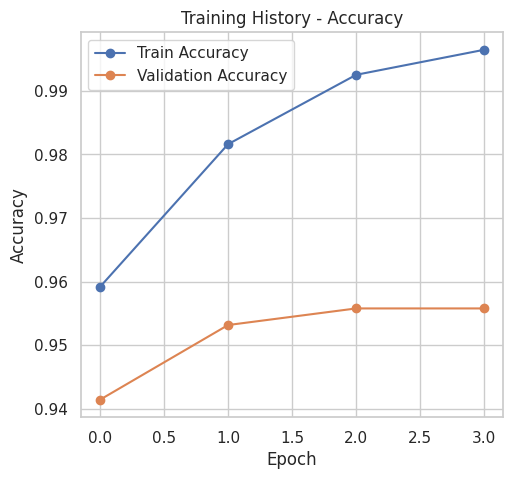

In [ ]:
# Plot Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(history['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Training History - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

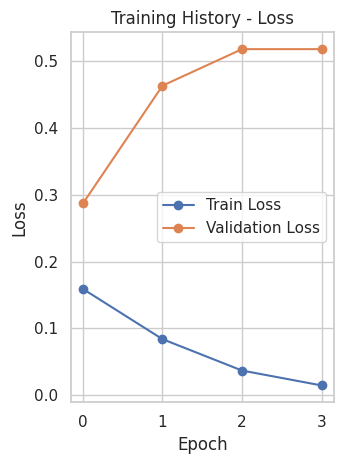

In [ ]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training History - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Bab 10: Evaluasi Model (Model Evaluation)**

### **10.1 Memuat Model Terbaik**


In [ ]:
# Load bobot terbaik
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

print("Model terbaik berhasil dimuat kembali untuk evaluasi.")

Model terbaik berhasil dimuat kembali untuk evaluasi.


### **10.2 Prediksi pada Data Test**


In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Ambil probabilitas tertinggi (Softmax)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            _, preds = torch.max(outputs.logits, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

# Jalankan fungsi prediksi
y_review_texts, y_pred, y_pred_probs, y_test_actual = get_predictions(
    model,
    test_data_loader
)

print("Prediksi pada Data Test selesai.")

Prediksi pada Data Test selesai.


### **10.3 Laporan Klasifikasi (Classification Report)**


In [ ]:
class_names = ['Negatif', 'Netral', 'Positif']

print("\n📊 CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_test_actual, y_pred, target_names=class_names))
print("="*60)

# Hitung akurasi total
acc = accuracy_score(y_test_actual, y_pred)
print(f"Akurasi Total: {acc:.4f}")


📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Negatif       0.90      0.93      0.92       780
      Netral       0.89      0.80      0.84       582
     Positif       0.97      0.98      0.98      3996

    accuracy                           0.96      5358
   macro avg       0.92      0.90      0.91      5358
weighted avg       0.96      0.96      0.96      5358

Akurasi Total: 0.9560


### **10.4 Confusion Matrix**


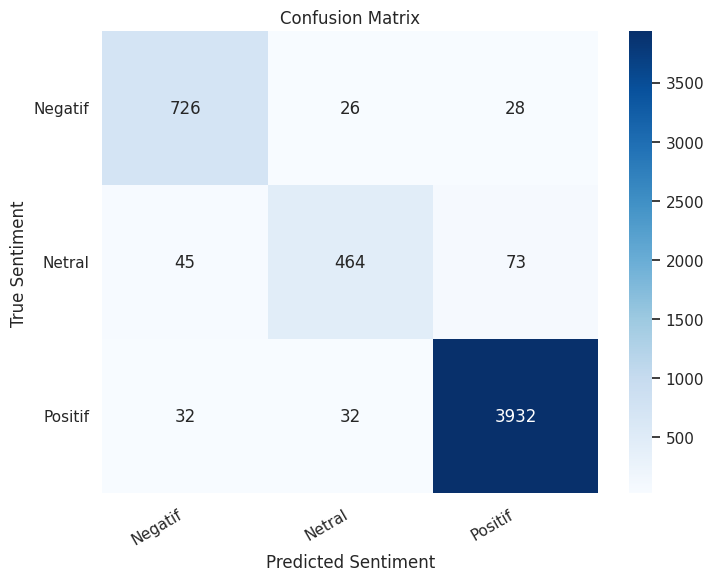

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')
    plt.title('Confusion Matrix')
    plt.show()

cm = confusion_matrix(y_test_actual, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
show_confusion_matrix(df_cm)

### **10.5 Analisis Kesalahan (Error Analysis)**


In [ ]:
# Gabungkan hasil ke DataFrame sementara
df_eval = pd.DataFrame({
    'review_text': y_review_texts,
    'actual': y_test_actual,
    'predicted': y_pred
})

# Filter hanya yang salah prediksi
wrong_predictions = df_eval[df_eval['actual'] != df_eval['predicted']]

print(f"Total Kesalahan Prediksi: {len(wrong_predictions)} dari {len(df_eval)} data test.")
print("\nContoh Kesalahan Model:")
print("-" * 80)

# Tampilkan 50 contoh kesalahan acak
if not wrong_predictions.empty:
    for idx, row in wrong_predictions.sample(min(50, len(wrong_predictions))).iterrows():
        act = class_names[row['actual']]
        pred = class_names[row['predicted']]
        print(f"Teks    : {row['review_text']}")
        print(f"Asli    : {act}")
        print(f"Prediksi: {pred}")
        print("-" * 80)
else:
    print("Wah! Model sempurna, tidak ada kesalahan (Sangat jarang terjadi).")

Total Kesalahan Prediksi: 236 dari 5358 data test.

Contoh Kesalahan Model:
--------------------------------------------------------------------------------
Teks    : halo doc tgl januari kemarin saya pakai apps halo doc saya transaksi rapid test tetapi masih menunggu konfirmasi setelah hari menunggu tiba transaksi di batalkan dengan alasan saya tidak datang tidak ada konfirmasi tiba di batalkan bagaimana soal biaya nya karena tidak bisa di refund
Asli    : Netral
Prediksi: Negatif
--------------------------------------------------------------------------------
Teks    : sangat membantu keluhan yang saya alami dimohon untuk mempermudah pada pembayar sprti lewat alfamart agar lebih mudah lagi dalam melakukan konsultasi terima kasih
Asli    : Netral
Prediksi: Positif
--------------------------------------------------------------------------------
Teks    : membantu banget buat saya ibu panikan
Asli    : Negatif
Prediksi: Positif
-----------------------------------------------------------

## **Bab 11: Penyimpanan Model (Saving Artifacts)**


### **11.1 Menyimpan Model dan Tokenizer**


In [ ]:
import shutil

# Nama folder penyimpanan
SAVE_DIR = "model_halodoc_sentiment"

# Buat folder jika belum ada
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

print(f"Menyimpan model dan tokenizer ke folder '{SAVE_DIR}'...")

# 1. Simpan Model (Bobot + Konfigurasi)
# Perhatikan: Kita simpan model yang sedang aktif (yang sudah di-load best weight-nya)
model_to_save = model.module if hasattr(model, 'module') else model  # Handle jika pakai DataParallel
model_to_save.save_pretrained(SAVE_DIR)

# 2. Simpan Tokenizer
tokenizer.save_pretrained(SAVE_DIR)

print("Berhasil disimpan!")
print(f"Isi folder '{SAVE_DIR}': {os.listdir(SAVE_DIR)}")

Menyimpan model dan tokenizer ke folder 'model_halodoc_sentiment'...
Berhasil disimpan!
Isi folder 'model_halodoc_sentiment': ['tokenizer_config.json', 'vocab.txt', 'special_tokens_map.json', 'model.safetensors', 'config.json']


### **11.2 Kompresi ke ZIP (Agar Mudah Download)**


In [ ]:
# Nama file zip output
zip_filename = "model_halodoc_sentiment.zip"

print(f"Mengompres folder ke '{zip_filename}'...")
shutil.make_archive("model_halodoc_sentiment", 'zip', SAVE_DIR)

print(f"File ZIP siap! Ukuran: {os.path.getsize(zip_filename) / 1e6:.2f} MB")

Mengompres folder ke 'model_halodoc_sentiment.zip'...
File ZIP siap! Ukuran: 462.19 MB


### **11.3 Uji Coba Load Model (Simulasi Deployment)**


In [ ]:
print("\nSimulasi Deployment: Memuat model dari folder simpanan...")

# 1. Load dari folder
loaded_tokenizer = BertTokenizer.from_pretrained(SAVE_DIR)
loaded_model = BertForSequenceClassification.from_pretrained(SAVE_DIR)
loaded_model.to(device)
loaded_model.eval()

# 2. Fungsi Prediksi Sederhana
def predict_sentiment(text, model, tokenizer):
    text = preprocess_text(text) # Jangan lupa preprocess dulu!

    encoded = tokenizer.encode_plus(
        text,
        max_length=128,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(output.logits, dim=1)

    label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
    return label_map[prediction.item()]

# 3. Test Drive dengan Kalimat Baru
test_sentences = [
    "Aplikasi ini sangat membantu saya konsultasi dokter tengah malam.",
    "Sering error pas mau bayar, tolong diperbaiki dong!",
    "Biasa aja sih aplikasinya, standar.",
    "Dokternya ramah banget tapi obatnya mahal."
]

print("\nHasil Uji Coba:")
print("-" * 50)
for text in test_sentences:
    sentiment = predict_sentiment(text, loaded_model, loaded_tokenizer)
    print(f"Teks     : {text}")
    print(f"Sentimen : {sentiment}")
    print("-" * 50)

### **11.4 Download File (Khusus Google Colab)**


In [ ]:
from google.colab import files

# Download file ZIP
print("⬇️ Mengunduh file model...")
files.download(zip_filename)

# Download juga file CSV hasil bersih (opsional, buat backup data)
df_final.to_csv("halodoc_reviews_clean_labeled.csv", index=False)
files.download("halodoc_reviews_clean_labeled.csv")

⬇️ Mengunduh file model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv('halodoc_reviews_labeled.csv')
df[df['label'] == 1]

,content,score,text_clean,sentiment_label,label
10,singkat padat jelas dan privasi terjaga,5,singkat padat jelas dan privasi terjaga,LABEL_1,1
12,udh isi form tp ga bs masuk chat room ih kzl m...,2,sudah isi form tapi tidak bisa masuk pesan roo...,LABEL_1,1
14,Sejauh ini cukup baik karena saya hanya menggu...,4,sejauh ini cukup baik karena saya hanya menggu...,LABEL_1,1
17,untuk sementara ini ok. karna baru pakai,5,untuk sementara ini oke karna baru pakai,LABEL_1,1
32,ok membntu untuk pertolongan pertama,5,oke membntu untuk pertolongan pertama,LABEL_1,1
...,...,...,...,...,...
53508,"Saat hampir tengah malam ada keluhan, dokter m...",5,saat hampir tengah malam ada keluhan dokter me...,LABEL_1,1
53525,Saya alergi deterjen n berobat ke dokter didae...,5,saya alergi deterjen berobat ke dokter didaera...,LABEL_1,1
53555,Perdana pakai aplikasi ini dan langsung konsul...,5,perdana pakai aplikasi ini dan langsung konsul...,LABEL_1,1
53569,Terimakasih buat aplikasi halodoc terutama pad...,5,terimakasih buat aplikasi halodoc terutama pad...,LABEL_1,1


# Sentiment Analysis Aplikasi Halodoc dengan IndoBERT

![Python](https://img.shields.io/badge/Python-3776AB?style=for-the-badge&logo=python&logoColor=white)
![PyTorch](https://img.shields.io/badge/PyTorch-EE4C2C?style=for-the-badge&logo=pytorch&logoColor=white)
![Transformers](https://img.shields.io/badge/HuggingFace-FFD21C?style=for-the-badge&logo=huggingface&logoColor=black)
![Streamlit](https://img.shields.io/badge/Streamlit-FF4B4B?style=for-the-badge&logo=streamlit&logoColor=white)

## 📋 Ringkasan Proyek

Proyek ini bertujuan untuk membangun dan melatih model Analisis Sentimen berbasis ulasan pengguna aplikasi Halodoc dari Google Play Store. Model ini menggunakan arsitektur IndoBERT yang telah di-*fine-tune* untuk mengklasifikasikan sentimen ulasan ke dalam tiga kategori: **Negatif (0), Netral (1), dan Positif (2)**. Data ulasan diperoleh melalui *scraping* Google Play Store dan dataset eksternal, kemudian melalui serangkaian tahapan preprocessing (pembersihan, normalisasi slang) dan pelabelan otomatis menggunakan model IndoBERT pre-trained, sebelum akhirnya di-*fine-tune* untuk tugas klasifikasi ini. Aplikasi Streamlit akan digunakan untuk deployment interaktif.

## ✨ Fitur Utama

*   **Akuisisi Data Otomatis:** Mengumpulkan ulasan aplikasi Halodoc langsung dari Google Play Store.
*   **Preprocessing Teks Komprehensif:** Tahapan pembersihan data seperti *case folding*, penghapusan URL/angka/tanda baca, normalisasi *slang word*, dan penghapusan duplikasi.
*   **Pelabelan Sentimen Otomatis:** Menggunakan model IndoBERT pre-trained (`mdhugol/indonesia-bert-sentiment-classification`) untuk melabeli ulasan, memfasilitasi pembuatan dataset berlabel dalam skala besar.
*   **Exploratory Data Analysis (EDA):** Analisis mendalam terhadap distribusi sentimen, panjang kalimat, *word cloud*, dan N-gram untuk memahami karakteristik data.
*   **Fine-tuning IndoBERT:** Melatih ulang model IndoBERT (`indobenchmark/indobert-base-p1`) untuk klasifikasi sentimen 3-kelas.
*   **Evaluasi Model:** Menggunakan metrik seperti *Classification Report* dan *Confusion Matrix* untuk menilai performa model.
*   **Deployment Ready:** Model dan *tokenizer* disimpan dalam format yang siap untuk deployment.

## 🚀 Struktur Folder Deployment

Untuk deployment aplikasi Streamlit, struktur folder yang disiapkan adalah sebagai berikut:

```
. (root folder proyek)
├── app.py                           # Aplikasi utama Streamlit (UI & interaksi)
├── model_inference.py               # Modul berisi logika pemuatan model & prediksi
├── model_halodoc_sentiment/         # Folder berisi model dan tokenizer yang sudah di-fine-tune
│   ├── config.json
│   ├── model.safetensors
│   ├── tokenizer_config.json
│   ├── vocab.txt
│   └── special_tokens_map.json
├── requirements.txt                 # Daftar pustaka Python yang dibutuhkan
└── README.md                        # Dokumentasi proyek (file ini)
```

## 🛠️ Instalasi & Penggunaan

### Persyaratan Sistem

*   Python 3.8+
*   pip (manajer paket Python)
*   Lingkungan virtual (direkomendasikan)

### Langkah-langkah Instalasi

1.  **Clone repositori ini** (jika ini adalah repositori Git Anda):
    ```bash
    git clone <URL_REPOSITORI_ANDA>
    cd <nama_folder_proyek>
    ```

2.  **Buat dan aktifkan lingkungan virtual:**
    ```bash
    python -m venv venv
    source venv/bin/activate  # Untuk Linux/macOS
    # atau
    venv\Scripts\activate      # Untuk Windows
    ```

3.  **Instal semua dependensi:**
    ```bash
    pip install -r requirements.txt
    ```

4.  **Pastikan folder `model_halodoc_sentiment` sudah tersedia** di direktori root proyek Anda, berisi file-file model dan tokenizer yang telah Anda latih dan simpan.

### Cara Menjalankan Aplikasi Streamlit

Setelah instalasi selesai dan lingkungan virtual aktif, Anda dapat menjalankan aplikasi Streamlit dengan perintah berikut:

```bash
streamlit run app.py
```

Aplikasi akan terbuka di browser web Anda (biasanya di `http://localhost:8501`).

## 🧠 Detail Model

Model yang digunakan untuk Analisis Sentimen adalah **IndoBERT Base P1** yang telah di-*fine-tune* pada dataset ulasan Halodoc yang sudah melalui preprocessing dan pelabelan otomatis. Model ini mampu mengklasifikasikan sentimen ke dalam 3 kategori: Negatif, Netral, dan Positif.

Proses pelatihan menggunakan *weighted cross-entropy loss* untuk menangani *imbalanced data*, *AdamW optimizer*, dan *linear scheduler with warmup*.

## 📊 Hasil dan Performa

Model mencapai akurasi validasi terbaik sekitar **0.9558** (95.58%). Namun, perlu dicatat bahwa model menunjukkan gejala *overfitting* ringan (nilai *train loss* yang sangat rendah dan *validation loss* yang lebih tinggi dan meningkat seiring *epoch*). Teknik *early stopping* (menyimpan model dengan akurasi validasi terbaik) telah diterapkan untuk mengatasi ini.

Berikut adalah ringkasan performa model pada *test set*:

```
              precision    recall  f1-score   support

     Negatif       0.90      0.93      0.92       780
      Netral       0.89      0.80      0.84       582
     Positif       0.97      0.98      0.98      3996

    accuracy                           0.96      5358
   macro avg       0.92      0.90      0.91      5358
weighted avg       0.96      0.96      0.96      5358

Akurasi Total: 0.9560
```

*Catatan: Untuk detail lengkap mengenai proses pelatihan, EDA, dan visualisasi, silakan lihat file Jupyter Notebook utama proyek ini.* (Anda bisa ganti ini dengan link ke notebook jika dihosting)

## 📧 Kontak

Jika Anda memiliki pertanyaan atau ingin berdiskusi lebih lanjut tentang proyek ini, silakan hubungi:

*   [Nama Anda/Email Anda]

---

In [ ]:
import os
from google.colab import files

readme_content = r"""
# Sentiment Analysis Aplikasi Halodoc dengan IndoBERT

![Python](https://img.shields.io/badge/Python-3776AB?style=for-the-badge&logo=python&logoColor=white)
![PyTorch](https://img.shields.io/badge/PyTorch-EE4C2C?style=for-the-badge&logo=pytorch&logoColor=white)
![Transformers](https://img.shields.io/badge/HuggingFace-FFD21C?style=for-the-badge&logo=huggingface&logoColor=black)
![Streamlit](https://img.shields.io/badge/Streamlit-FF4B4B?style=for-the-badge&logo=streamlit&logoColor=white)

## 📋 Ringkasan Proyek

Proyek ini bertujuan untuk membangun dan melatih model Analisis Sentimen berbasis ulasan pengguna aplikasi Halodoc dari Google Play Store. Model ini menggunakan arsitektur IndoBERT yang telah di-*fine-tune* untuk mengklasifikasikan sentimen ulasan ke dalam tiga kategori: **Negatif (0), Netral (1), dan Positif (2)**. Data ulasan diperoleh melalui *scraping* Google Play Store dan dataset eksternal, kemudian melalui serangkaian tahapan preprocessing (pembersihan, normalisasi slang) dan pelabelan otomatis menggunakan model IndoBERT pre-trained, sebelum akhirnya di-*fine-tune* untuk tugas klasifikasi ini. Aplikasi Streamlit akan digunakan untuk deployment interaktif.

## ✨ Fitur Utama

*   **Akuisisi Data Otomatis:** Mengumpulkan ulasan aplikasi Halodoc langsung dari Google Play Store.
*   **Preprocessing Teks Komprehensif:** Tahapan pembersihan data seperti *case folding*, penghapusan URL/angka/tanda baca, normalisasi *slang word*, dan penghapusan duplikasi.
*   **Pelabelan Sentimen Otomatis:** Menggunakan model IndoBERT pre-trained (`mdhugol/indonesia-bert-sentiment-classification`) untuk melabeli ulasan, memfasilitasi pembuatan dataset berlabel dalam skala besar.
*   **Exploratory Data Analysis (EDA):** Analisis mendalam terhadap distribusi sentimen, panjang kalimat, *word cloud*, dan N-gram untuk memahami karakteristik data.
*   **Fine-tuning IndoBERT:** Melatih ulang model IndoBERT (`indobenchmark/indobert-base-p1`) untuk klasifikasi sentimen 3-kelas.
*   **Evaluasi Model:** Menggunakan metrik seperti *Classification Report* dan *Confusion Matrix* untuk menilai performa model.
*   **Deployment Ready:** Model dan *tokenizer* disimpan dalam format yang siap untuk deployment.

## 🚀 Struktur Folder Deployment

Untuk deployment aplikasi Streamlit, struktur folder yang disiapkan adalah sebagai berikut:

```
. (root folder proyek)
├── app.py                           # Aplikasi utama Streamlit (UI & interaksi)
├── model_inference.py               # Modul berisi logika pemuatan model & prediksi
├── model_halodoc_sentiment/         # Folder berisi model dan tokenizer yang sudah di-fine-tune
│   ├── config.json
│   ├── model.safetensors
│   ├── tokenizer_config.json
│   ├── vocab.txt
│   └── special_tokens_map.json
├── requirements.txt                 # Daftar pustaka Python yang dibutuhkan
└── README.md                        # Dokumentasi proyek (file ini)
```

## 🛠️ Instalasi & Penggunaan

### Persyaratan Sistem

*   Python 3.8+
*   pip (manajer paket Python)
*   Lingkungan virtual (direkomendasikan)

### Langkah-langkah Instalasi

1.  **Clone repositori ini** (jika ini adalah repositori Git Anda):
    ```bash
    git clone <URL_REPOSITORI_ANDA>
    cd <nama_folder_proyek>
    ```

2.  **Buat dan aktifkan lingkungan virtual:**
    ```bash
    python -m venv venv
    source venv/bin/activate  # Untuk Linux/macOS
    # atau
    venv\Scripts\activate      # Untuk Windows
    ```

3.  **Instal semua dependensi:**
    ```bash
    pip install -r requirements.txt
    ```

4.  **Pastikan folder `model_halodoc_sentiment` sudah tersedia** di direktori root proyek Anda, berisi file-file model dan tokenizer yang telah Anda latih dan simpan.

### Cara Menjalankan Aplikasi Streamlit

Setelah instalasi selesai dan lingkungan virtual aktif, Anda dapat menjalankan aplikasi Streamlit dengan perintah berikut:

```bash
streamlit run app.py
```

Aplikasi akan terbuka di browser web Anda (biasanya di `http://localhost:8501`).

## 🧠 Detail Model

Model yang digunakan untuk Analisis Sentimen adalah **IndoBERT Base P1** yang telah di-*fine-tune* pada dataset ulasan Halodoc yang sudah melalui preprocessing dan pelabelan otomatis. Model ini mampu mengklasifikasikan sentimen ke dalam 3 kategori: Negatif, Netral, dan Positif.

Proses pelatihan menggunakan *weighted cross-entropy loss* untuk menangani *imbalanced data*, *AdamW optimizer*, dan *linear scheduler with warmup*.

## 📊 Hasil dan Performa

Model mencapai akurasi validasi terbaik sekitar **0.9558** (95.58%). Namun, perlu dicatat bahwa model menunjukkan gejala *overfitting* ringan (nilai *train loss* yang sangat rendah dan *validation loss* yang lebih tinggi dan meningkat seiring *epoch*). Teknik *early stopping* (menyimpan model dengan akurasi validasi terbaik) telah diterapkan untuk mengatasi ini.

Berikut adalah ringkasan performa model pada *test set*:

```
              precision    recall  f1-score   support

     Negatif       0.90      0.93      0.92       780
      Netral       0.89      0.80      0.84       582
     Positif       0.97      0.98      0.98      3996

    accuracy                           0.96      5358
   macro avg       0.92      0.90      0.91      5358
weighted avg       0.96      0.96      0.96      5358

Akurasi Total: 0.9560
```

*Catatan: Untuk detail lengkap mengenai proses pelatihan, EDA, dan visualisasi, silakan lihat file Jupyter Notebook utama proyek ini.* (Anda bisa ganti ini dengan link ke notebook jika dihosting)

## 📧 Kontak

Jika Anda memiliki pertanyaan atau ingin berdiskusi lebih lanjut tentang proyek ini, silakan hubungi:

*   [Nama Anda/Email Anda]

---"""

# Simpan konten ke file README.md
readme_filename = "README.md"
with open(readme_filename, "w", encoding="utf-8") as f:
    f.write(readme_content)

# Memperbaiki baris ini
print(f"File '{readme_filename}' berhasil dibuat.")

File 'README.md' berhasil dibuat.


<>:65: SyntaxWarning: invalid escape sequence '\S'
<>:65: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-1088070683.py:65: SyntaxWarning: invalid escape sequence '\S'
  venv\Scripts\activate      # Untuk Windows


In [ ]:
from google.colab import files

readme_filename = "README.md"
print(f"⬇️ Mengunduh file '{readme_filename}'...")
files.download(readme_filename)
print(f"File '{readme_filename}' berhasil diunduh.")

⬇️ Mengunduh file 'README.md'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File 'README.md' berhasil diunduh.


In [ ]:
requirements_content = """
pandas
numpy
matplotlib
seaborn
google-play-scraper
nltk
Sastrawi
scikit-learn
torch
transformers
tqdm
wordcloud
"""

# Simpan konten ke file requirements.txt
requirements_filename = "requirements.txt"
with open(requirements_filename, "w", encoding="utf-8") as f:
    f.write(requirements_content)

print(f"File '{requirements_filename}' berhasil dibuat.")

File 'requirements.txt' berhasil dibuat.


In [ ]:
from google.colab import files

requirements_filename = "requirements.txt"
print(f"⬇️ Mengunduh file '{requirements_filename}'...")
files.download(requirements_filename)
print(f"File '{requirements_filename}' berhasil diunduh.")

⬇️ Mengunduh file 'requirements.txt'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File 'requirements.txt' berhasil diunduh.
